Author: Tashay Green

An interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". For example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.

So let's test if the last link holds. If we have data on the energy consumed by a building how well does that relate to the number of units in the building?

In [1]:
import geopandas as gp
import pandas as pd
import pylab as pl
import os
import json
import zipfile
from pandas.tools.plotting import scatter_matrix

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
os.getenv('PUIDATA')
dataFile = os.getenv('PUIDATA') + '/' + 'Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv'
nrg = pd.read_csv(dataFile)

In [3]:
myzip = zipfile.ZipFile(os.getenv('PUIDATA') + '/' + 'mn_mappluto_16v1.zip')
myzip.extractall()
myzip.open('MNMapPLUTO.shp')
bsize = gp.read_file('MNMapPLUTO.shp')

In [4]:
nrg.columns
nrg.rename(columns={'NYC Borough, Block, and Lot (BBL)':'BBL'}, inplace=True)
nrg = nrg [['BBL','Zip Code','Reported Property Floor Area (Building(s)) (ft²)', 'DOF Number of Buildings', 'Site EUI(kBtu/ft2)']]
nrg.head()

,BBL,Zip Code,Reported Property Floor Area (Building(s)) (ft²),DOF Number of Buildings,Site EUI(kBtu/ft2)
0,1.000410e+09,NaN,918919,NaN,NaN
1,4.021460e+09,11375.0,NaN,1.0,NaN
2,2.027620e+09,NaN,64200,NaN,NaN
3,1.006700e+09,10001.0,NaN,1.0,NaN
4,2.048300e+09,NaN,50000,NaN,NaN


In [5]:
bsize.columns
bsize = bsize[['BBL','BldgClass','YearBuilt','ZipCode']]
bsize.head()

,BBL,BldgClass,YearBuilt,ZipCode
0,1.015450e+09,C7,1920,10028
1,1.007238e+09,R4,1914,10001
2,1.016800e+09,C1,1910,10029
3,1.013850e+09,D4,1928,10021
4,1.011970e+09,D1,1900,10024


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f14f9404cf8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f14f9f95240>]], dtype=object)

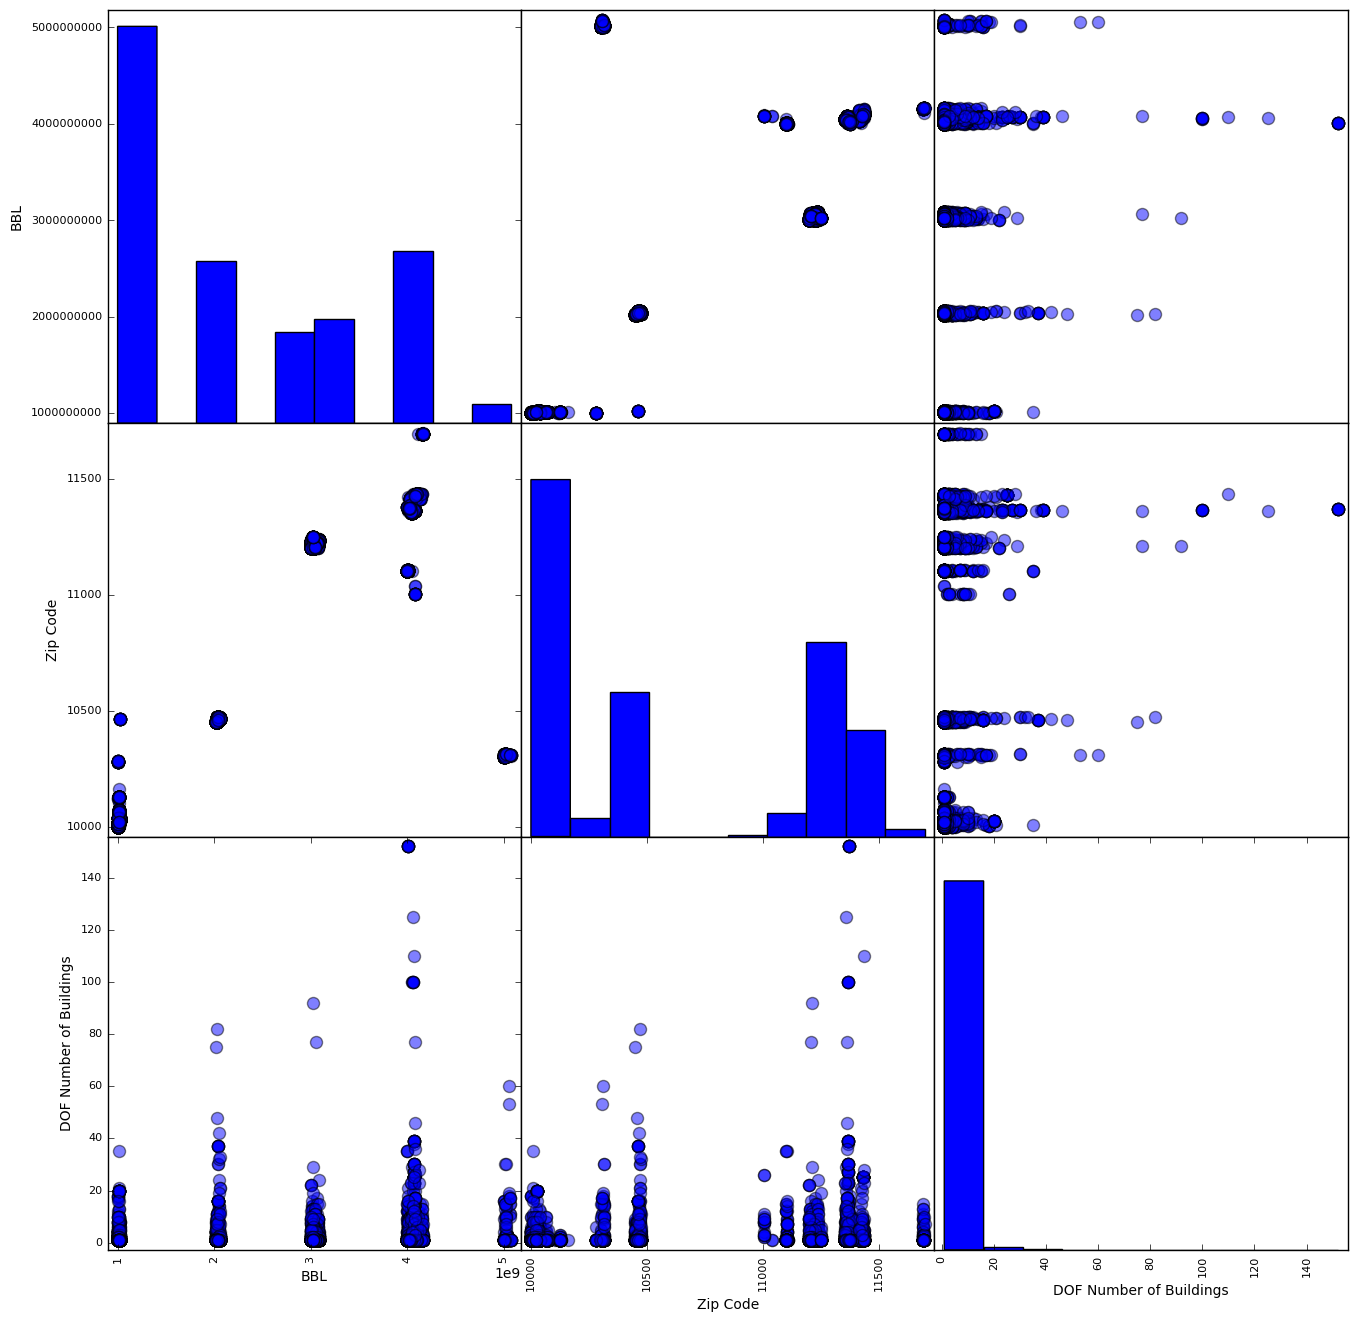

In [6]:
# Scatter matrix of nrg data.
scatter_matrix (nrg, s=300, figsize=(16, 16))

Figure 1: Scatter matrix of all numerical values in segmented NRG dataframe. 

In [7]:
def canconvert(mydata):
    """
    This function returns True if arguments passed in are able to be converted to floats, and returns False otherwise. 
    """
    try :
        float(mydata)
        return True
    except ValueError:
        return False

In [8]:
indx = (np.vectorize(canconvert)(nrg['Site EUI(kBtu/ft2)']))
print ("invalid entries changed to NaN %d"%sum(indx))
nrg['Site EUI(kBtu/ft2)'][~indx] = float('NaN')

invalid entries changed to NaN 15513
